<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/FT_Transformer(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== F1-Transformer Crop Production Classification (3 Classes) ===

Using device: cpu

Loading datasets...
Train set shape: (3584, 84)
Validation set shape: (768, 84)
Test set shape: (768, 84)
Feature dimensions: 83
Label distribution in training set:
  Low: 1184 (33.0%)
  Medium: 1218 (34.0%)
  High: 1182 (33.0%)

Quantile thresholds:
  Low: ≤ 1018.000 M.Ton
  Medium: 1018.000 - 3979.000 M.Ton
  High: > 3979.000 M.Ton
Model parameters: 614,403
Trainable parameters: 614,403

Training model for 50 epochs...
Epoch [10/50]
  Train Loss: 0.3374, Train Acc: 87.11%, Train F1: 0.8723
  Val Loss: 0.2976, Val Acc: 87.89%, Val F1: 0.8800
Epoch [20/50]
  Train Loss: 0.2595, Train Acc: 90.57%, Train F1: 0.9060
  Val Loss: 0.3113, Val Acc: 88.15%, Val F1: 0.8818
Epoch [30/50]
  Train Loss: 0.1673, Train Acc: 93.47%, Train F1: 0.9349
  Val Loss: 0.2652, Val Acc: 91.15%, Val F1: 0.9120
Epoch [40/50]
  Train Loss: 0.1665, Train Acc: 94.11%, Train F1: 0.9413
  Val Loss: 0.2402, Val Acc: 91.80%, Val F1: 

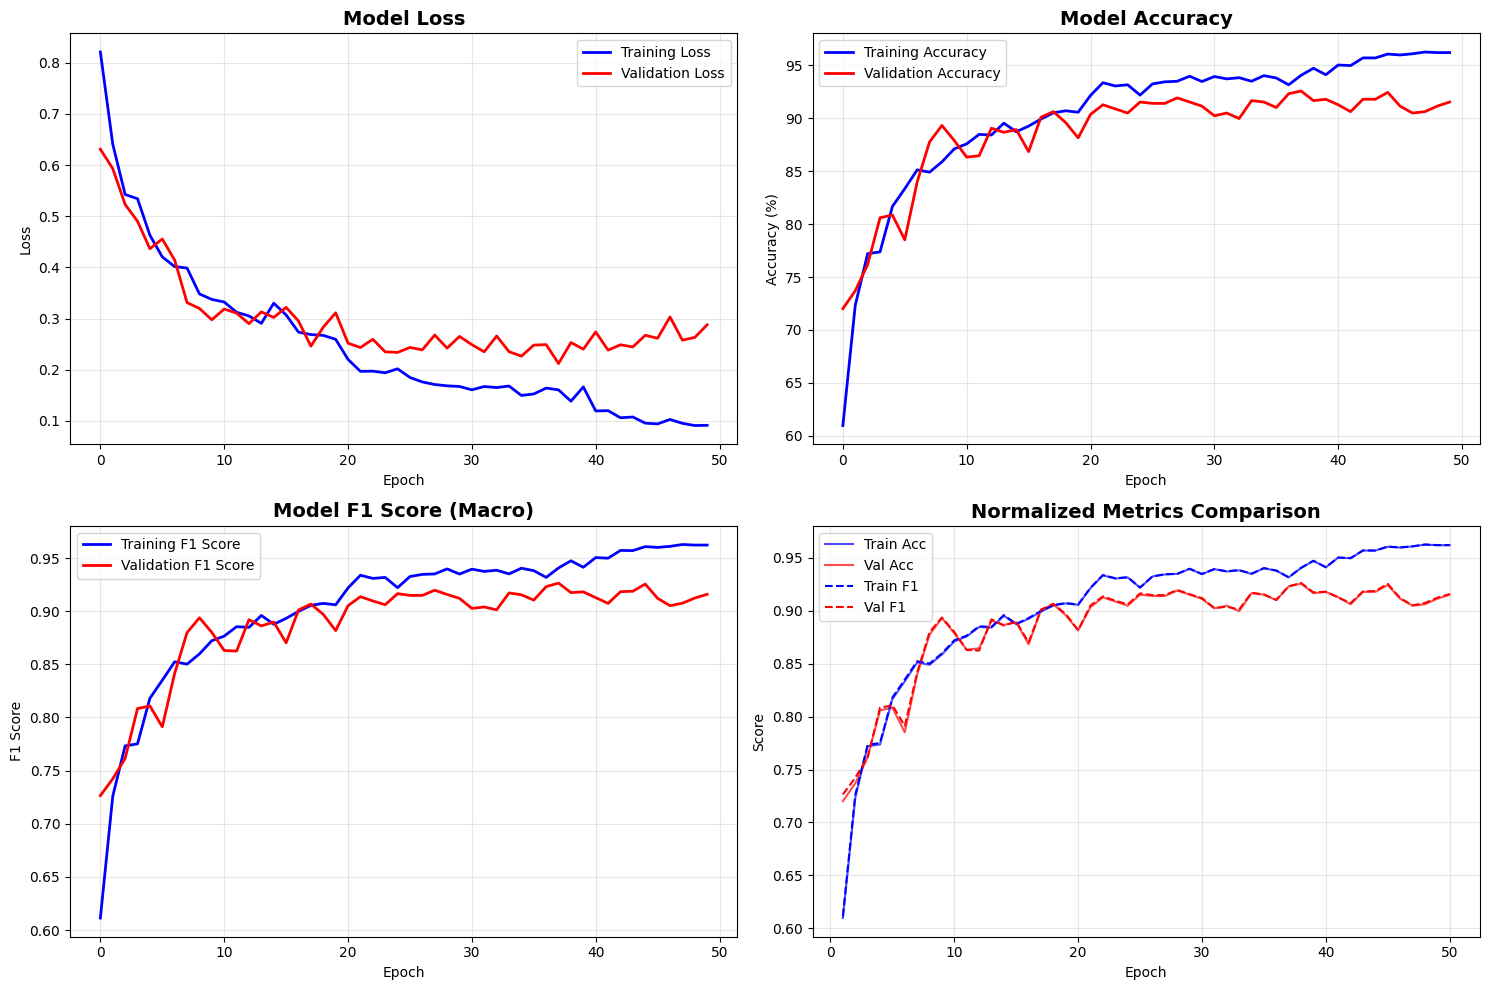


=== Validation Set Evaluation ===
Validation Metrics:
  Accuracy: 0.9154
  Precision (Macro): 0.9160
  Recall (Macro): 0.9165
  F1 Score (Macro): 0.9159
  F1 Score (Weighted): 0.9150

=== Test Set Evaluation ===
Test Metrics:
  Accuracy: 0.9284
  Precision (Macro): 0.9299
  Recall (Macro): 0.9287
  F1 Score (Macro): 0.9292
  F1 Score (Weighted): 0.9286

Plotting confusion matrices...


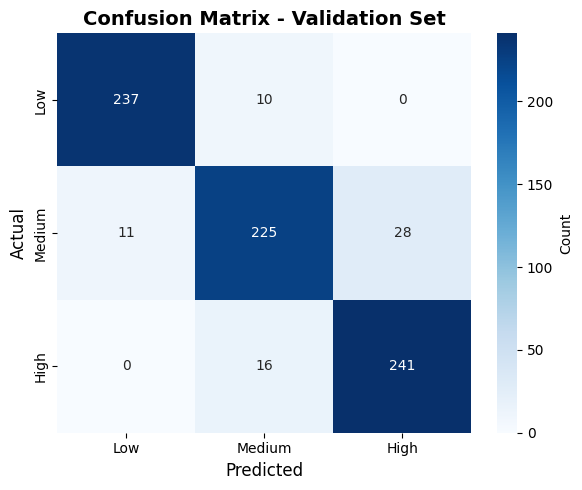

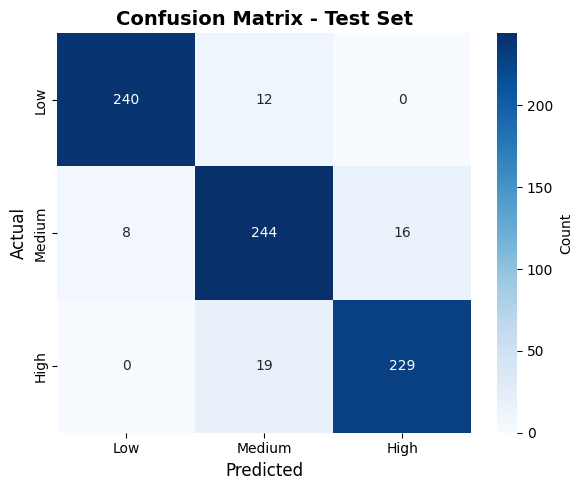


=== Detailed Classification Report - Validation Set ===
              precision    recall  f1-score   support

         Low       0.96      0.96      0.96       247
      Medium       0.90      0.85      0.87       264
        High       0.90      0.94      0.92       257

    accuracy                           0.92       768
   macro avg       0.92      0.92      0.92       768
weighted avg       0.92      0.92      0.91       768


=== Detailed Classification Report - Test Set ===
              precision    recall  f1-score   support

         Low       0.97      0.95      0.96       252
      Medium       0.89      0.91      0.90       268
        High       0.93      0.92      0.93       248

    accuracy                           0.93       768
   macro avg       0.93      0.93      0.93       768
weighted avg       0.93      0.93      0.93       768


=== Final Results Summary ===
   Dataset  Accuracy  Precision (Macro)  Recall (Macro)  F1 Score (Macro)  F1 Score (Weighted)
Vali

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class CropDataset(Dataset):
    """Custom Dataset for crop production data"""
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class F1TransformerModel(nn.Module):
    """F1-Transformer model for crop production classification"""
    def __init__(self, input_dim, num_classes=3, d_model=128, nhead=8, num_layers=3, dropout=0.1):
        super(F1TransformerModel, self).__init__()

        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)

        # Positional encoding (simple learned embedding)
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, num_classes)
        )

    def forward(self, x):
        # Project input to d_model dimensions
        x = self.input_projection(x)  # [batch_size, d_model]

        # Add batch and sequence dimensions for transformer
        x = x.unsqueeze(1)  # [batch_size, 1, d_model]

        # Add positional encoding
        x = x + self.pos_embedding

        # Pass through transformer encoder
        x = self.transformer_encoder(x)  # [batch_size, 1, d_model]

        # Remove sequence dimension and classify
        x = x.squeeze(1)  # [batch_size, d_model]
        output = self.classifier(x)

        return output

def load_and_preprocess_data():
    """Load and preprocess the CSV files"""
    print("Loading datasets...")

    # Load datasets
    train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

    print(f"Train set shape: {train_df.shape}")
    print(f"Validation set shape: {val_df.shape}")
    print(f"Test set shape: {test_df.shape}")

    # Handle missing values
    for df in [train_df, val_df, test_df]:
        df.fillna(df.mean(numeric_only=True), inplace=True)

    # Create quantile-based labels for production (3 classes instead of 5)
    production_col = 'Production (M.Ton)'

    # Calculate quantiles from training data only - using tertiles for 3 classes
    quantiles = train_df[production_col].quantile([0.33, 0.67]).values

    def create_labels(production_values, quantiles):
        """Create 3-level labels based on quantiles"""
        labels = []
        for val in production_values:
            if val <= quantiles[0]:
                labels.append(0)  # Low
            elif val <= quantiles[1]:
                labels.append(1)  # Medium
            else:
                labels.append(2)  # High
        return np.array(labels)

    # Create labels
    train_labels = create_labels(train_df[production_col].values, quantiles)
    val_labels = create_labels(val_df[production_col].values, quantiles)
    test_labels = create_labels(test_df[production_col].values, quantiles)

    # Remove target column from features
    feature_cols = [col for col in train_df.columns if col != production_col]

    X_train = train_df[feature_cols].values
    X_val = val_df[feature_cols].values
    X_test = test_df[feature_cols].values

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Feature dimensions: {X_train_scaled.shape[1]}")
    print(f"Label distribution in training set:")
    unique, counts = np.unique(train_labels, return_counts=True)
    label_names = ['Low', 'Medium', 'High']
    for i, (label, count) in enumerate(zip(unique, counts)):
        print(f"  {label_names[label]}: {count} ({count/len(train_labels)*100:.1f}%)")

    # Print quantile thresholds
    print(f"\nQuantile thresholds:")
    print(f"  Low: ≤ {quantiles[0]:.3f} M.Ton")
    print(f"  Medium: {quantiles[0]:.3f} - {quantiles[1]:.3f} M.Ton")
    print(f"  High: > {quantiles[1]:.3f} M.Ton")

    return (X_train_scaled, train_labels, X_val_scaled, val_labels,
            X_test_scaled, test_labels, scaler, quantiles)

def train_model(model, train_loader, val_loader, num_epochs=50, device='cpu'):
    """Train the F1-Transformer model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_scores = []
    val_f1_scores = []

    best_val_f1 = 0
    best_model_state = None

    print(f"Training model for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_predictions = []
        train_true = []

        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()

            train_predictions.extend(predicted.cpu().numpy())
            train_true.extend(batch_labels.cpu().numpy())

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_predictions = []
        val_true = []

        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()

                val_predictions.extend(predicted.cpu().numpy())
                val_true.extend(batch_labels.cpu().numpy())

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        train_f1_macro = f1_score(train_true, train_predictions, average='macro')
        val_f1_macro = f1_score(val_true, val_predictions, average='macro')

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_f1_scores.append(train_f1_macro)
        val_f1_scores.append(val_f1_macro)

        # Save best model based on macro F1 score
        if val_f1_macro > best_val_f1:
            best_val_f1 = val_f1_macro
            best_model_state = model.state_dict().copy()

        scheduler.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1_macro:.4f}')
            print(f'  Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1_macro:.4f}')

    # Load best model
    model.load_state_dict(best_model_state)
    print(f'Best validation macro F1 score: {best_val_f1:.4f}')

    return model, train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores

def evaluate_model(model, data_loader, device='cpu'):
    """Evaluate model and return predictions and true labels"""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch_features, batch_labels in data_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(batch_labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

def calculate_metrics(y_true, y_pred):
    """Calculate all classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return {
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Recall (Macro)': recall_macro,
        'F1 Score (Macro)': f1_macro,
        'F1 Score (Weighted)': f1_weighted
    }

def plot_confusion_matrix(y_true, y_pred, title, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {title}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores):
    """Plot training history with enhanced visualization"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    ax1.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue', linewidth=2)
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red', linewidth=2)
    ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot F1 scores
    ax3.plot(train_f1_scores, label='Training F1 Score', color='blue', linewidth=2)
    ax3.plot(val_f1_scores, label='Validation F1 Score', color='red', linewidth=2)
    ax3.set_title('Model F1 Score (Macro)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Score')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot comparison of all metrics
    epochs = range(1, len(train_losses) + 1)
    ax4.plot(epochs, np.array(train_accuracies)/100, label='Train Acc', color='blue', alpha=0.7)
    ax4.plot(epochs, np.array(val_accuracies)/100, label='Val Acc', color='red', alpha=0.7)
    ax4.plot(epochs, train_f1_scores, label='Train F1', color='blue', linestyle='--')
    ax4.plot(epochs, val_f1_scores, label='Val F1', color='red', linestyle='--')
    ax4.set_title('Normalized Metrics Comparison', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Score')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    """Main training and evaluation pipeline"""
    print("=== F1-Transformer Crop Production Classification (3 Classes) ===\n")

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")

    # Load and preprocess data
    (X_train, y_train, X_val, y_val, X_test, y_test,
     scaler, quantiles) = load_and_preprocess_data()

    # Create datasets and data loaders
    train_dataset = CropDataset(X_train, y_train)
    val_dataset = CropDataset(X_val, y_val)
    test_dataset = CropDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model (3 classes instead of 5)
    input_dim = X_train.shape[1]
    model = F1TransformerModel(input_dim=input_dim, num_classes=3).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")

    # Train model
    num_epochs = 50
    model, train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s = train_model(
        model, train_loader, val_loader, num_epochs, device
    )

    # Plot training history
    print("\nPlotting training history...")
    plot_training_history(train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s)

    # Evaluate on validation set
    print("\n=== Validation Set Evaluation ===")
    val_pred, val_true = evaluate_model(model, val_loader, device)
    val_metrics = calculate_metrics(val_true, val_pred)

    print("Validation Metrics:")
    for metric, value in val_metrics.items():
        print(f"  {metric}: {value:.4f}")

    # Evaluate on test set
    print("\n=== Test Set Evaluation ===")
    test_pred, test_true = evaluate_model(model, test_loader, device)
    test_metrics = calculate_metrics(test_true, test_pred)

    print("Test Metrics:")
    for metric, value in test_metrics.items():
        print(f"  {metric}: {value:.4f}")

    # Class names (3 classes)
    class_names = ['Low', 'Medium', 'High']

    # Plot confusion matrices
    print("\nPlotting confusion matrices...")
    plot_confusion_matrix(val_true, val_pred, "Validation Set", class_names)
    plot_confusion_matrix(test_true, test_pred, "Test Set", class_names)

    # Detailed classification reports
    print("\n=== Detailed Classification Report - Validation Set ===")
    print(classification_report(val_true, val_pred, target_names=class_names))

    print("\n=== Detailed Classification Report - Test Set ===")
    print(classification_report(test_true, test_pred, target_names=class_names))

    # Enhanced summary table
    print("\n=== Final Results Summary ===")
    results_df = pd.DataFrame({
        'Dataset': ['Validation', 'Test'],
        'Accuracy': [val_metrics['Accuracy'], test_metrics['Accuracy']],
        'Precision (Macro)': [val_metrics['Precision (Macro)'], test_metrics['Precision (Macro)']],
        'Recall (Macro)': [val_metrics['Recall (Macro)'], test_metrics['Recall (Macro)']],
        'F1 Score (Macro)': [val_metrics['F1 Score (Macro)'], test_metrics['F1 Score (Macro)']],
        'F1 Score (Weighted)': [val_metrics['F1 Score (Weighted)'], test_metrics['F1 Score (Weighted)']]
    })

    print(results_df.round(4).to_string(index=False))

    # Class-wise performance analysis
    print("\n=== Class-wise Performance Analysis ===")
    print("Validation Set:")
    val_report = classification_report(val_true, val_pred, target_names=class_names, output_dict=True)
    for class_name in class_names:
        metrics = val_report[class_name]
        print(f"  {class_name}: Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")

    print("Test Set:")
    test_report = classification_report(test_true, test_pred, target_names=class_names, output_dict=True)
    for class_name in class_names:
        metrics = test_report[class_name]
        print(f"  {class_name}: Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")

    return model, scaler, quantiles

if __name__ == "__main__":
    # Run the complete pipeline
    trained_model, fitted_scaler, production_quantiles = main()

    print("\n=== Training Complete ===")
    print("Model trained successfully!")
    print("All metrics calculated and plots generated.")
    print(f"Production quantile thresholds saved: {production_quantiles}")